## Setup

### Import Libraries


In [1]:
import pickle
from datasets import load_from_disk
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import segmentation_models_pytorch as smp
from pathlib import Path
import json
import matplotlib.pyplot as plt
import time

/opt/anaconda3/envs/gen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Test Dataset

In [2]:
# Load split indices
with open('./cache/splits.pkl', 'rb') as f:
    splits = pickle.load(f)

test_indices = splits['test_indices']

# Load dataset and create test split
dataset = load_from_disk("./data")
test_split = dataset["labelled"].select(test_indices)

print(f"✓ Loaded test split: {len(test_split)} images")

✓ Loaded test split: 165 images


### Load Best Model (Dice Loss + Increased Stem Weight)

In [3]:
# Set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("✓ Using CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✓ Using MPS (Apple Silicon)")
else:
    device = torch.device("cpu")
    print("⚠ Using CPU")

# Load experiment summary
experiment_name = "02_dice_stem"
summary_path = f"./cache/{experiment_name}_summary.json"

with open(summary_path, 'r') as f:
    experiment_summary = json.load(f)

print(f"\n✓ Loaded experiment summary: {experiment_name}")
print(f"  Best epoch: {experiment_summary['best_epoch']}")
print(f"  Best validation mIoU: {experiment_summary['best_val_miou']:.4f}")
print(f"  Training time: {experiment_summary['training_time_minutes']} minutes")

✓ Using MPS (Apple Silicon)

✓ Loaded experiment summary: 02_dice_stem
  Best epoch: 25
  Best validation mIoU: 0.6692
  Training time: 78 minutes


In [4]:
# Load model architecture from hyperparameters
NUM_CLASSES = 4
encoder_name = experiment_summary['hyperparameters']['encoder']

model = smp.DeepLabV3Plus(
    encoder_name=encoder_name,
    encoder_weights=None,  # We'll load trained weights
    in_channels=3,
    classes=NUM_CLASSES,
)

# Load trained weights (weights_only=False since this is our own trusted checkpoint)
checkpoint_path = f"./cache/{experiment_name}.pth"
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"\n✓ Loaded model from: {checkpoint_path}")
print(f"  Architecture: DeepLabV3+ with {encoder_name} encoder")
print(f"  Classes: {NUM_CLASSES}")


✓ Loaded model from: ./cache/02_dice_stem.pth
  Architecture: DeepLabV3+ with resnet50 encoder
  Classes: 4


### Define Data Transforms and Dataset

In [5]:
# Define ImageNet normalisation constants (for pretrained ResNet)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Create a custom class for the segmentation transforms
class SegmentationTransform:
    def __init__(self, image_size=512, augment=False):
        self.image_size = image_size
        self.augment = augment
    
    def __call__(self, image, mask):
        # Resize image and mask to the same size
        resize_image = transforms.Resize((self.image_size, self.image_size), 
                                   interpolation=transforms.InterpolationMode.BILINEAR) # Smoothing for image
        resize_mask = transforms.Resize((self.image_size, self.image_size),
                                        interpolation=transforms.InterpolationMode.NEAREST) # Nearest neighbour for mask
        
        image = resize_image(image)
        mask = resize_mask(mask)
        
        # Augment training data (improves generalisation and reduces overfitting)
        if self.augment:
            # Random horizontal flip
            if np.random.random() > 0.5:
                image = transforms.functional.hflip(image)
                mask = transforms.functional.hflip(mask)
            
            # Random rotation
            angle = np.random.uniform(-15, 15)
            image = transforms.functional.rotate(image, angle, 
                                                 interpolation=transforms.InterpolationMode.BILINEAR) # Smoothing for image
            mask = transforms.functional.rotate(mask, angle,
                                                interpolation=transforms.InterpolationMode.NEAREST) # Nearest neighbour for mask
            
            # Random colour jitter
            color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
            image = color_jitter(image)
        
        return image, mask

# Create a custom class for the GWFSS dataset
class GWFSSDataset(Dataset):
    def __init__(self, dataset_split, transform=None):
        self.dataset = dataset_split
        self.transform = transform
        self.rgb_to_class = {
            (0, 0, 0): 0,
            (214, 255, 50): 1,
            (50, 132, 255): 2,
            (50, 255, 132): 3,
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        image = example['image']
        mask_rgb = example['mask']
        mask_array = np.array(mask_rgb)

        # Create an empty array with the same dimensions as the mask to store the class labels
        mask = np.zeros((mask_array.shape[0], mask_array.shape[1]), dtype=np.uint8)

        # For each RGB colour in the mapping, set the corresponding pixels in the mask to the class label
        for rgb_tuple, class_id in self.rgb_to_class.items():
            mask[(mask_array == rgb_tuple).all(axis=2)] = class_id
        
        # Convert the mask array to a greyscale PIL Image
        mask = Image.fromarray(mask, mode='L')
        
        # Transform image and mask (done together to maintain alignment)
        if self.transform:
            image, mask = self.transform(image, mask)
        
        # Convert to tensors
        image = transforms.ToTensor()(image)
        mask = torch.from_numpy(np.array(mask)).long()
        
        # Normalise image
        normalize = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        image = normalize(image)
        
        return image, mask

# Create test dataset and dataloader (no augmentation for test set)
test_transform = SegmentationTransform(image_size=512, augment=False)
test_dataset = GWFSSDataset(test_split, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

print(f"✓ Created test dataset: {len(test_dataset)} images")
print(f"✓ Created test dataloader: {len(test_loader)} batches")

✓ Created test dataset: 165 images
✓ Created test dataloader: 21 batches


### Define Evaluation Metrics

In [6]:
# Define IoU metric
def calculate_iou(pred_mask, true_mask, num_classes=4):
    ious = []
    pred_mask = pred_mask.cpu().numpy()
    true_mask = true_mask.cpu().numpy()
    
    for cls in range(num_classes):
        # Create binary masks
        pred_cls = (pred_mask == cls)
        true_cls = (true_mask == cls)
        
        # Use masks to calculate intersection and union
        intersection = np.logical_and(pred_cls, true_cls).sum()
        union = np.logical_or(pred_cls, true_cls).sum()
        
        # Handle division by zero if class is not present in either mask
        if union == 0:
            # Both masks correctly have no pixels of this class → perfect IoU
            iou = 1.0 if intersection == 0 else 0.0
        else:
            iou = intersection / union

        ious.append(iou)
    
    return ious

print("✓ Defined IoU metric")

✓ Defined IoU metric


## Evaluation

### Run Inference on Test Set

In [14]:
# Class names
class_names = ['Background', 'Leaf', 'Stem', 'Head']

# Initialise metrics storage
test_ious = []

# Run inference
print(f"Running inference on {len(test_dataset)} test images...")
print(f"Batches to process: {len(test_loader)}")
print()

start_time = time.time()

model.eval()
with torch.no_grad():
    for batch_idx, (images, masks) in enumerate(test_loader):
        # Move to device
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)
        
        # Calculate IoU for each image in batch
        for i in range(predictions.shape[0]):
            iou = calculate_iou(predictions[i], masks[i], num_classes=NUM_CLASSES)
            test_ious.append(iou)
        
        # Progress update
        if (batch_idx + 1) % 5 == 0 or (batch_idx + 1) == len(test_loader):
            print(f"  Processed {(batch_idx + 1) * len(images)}/{len(test_dataset)} images...")

inference_time = time.time() - start_time

# Convert to numpy array for easier calculation
test_ious = np.array(test_ious)

# Calculate mean IoU per class
test_class_ious = test_ious.mean(axis=0)
test_miou = test_class_ious.mean()

print(f"\n✓ Inference complete in {inference_time:.2f} seconds")


Running inference on 165 test images...
Batches to process: 21

  Processed 40/165 images...
  Processed 80/165 images...
  Processed 120/165 images...
  Processed 160/165 images...
  Processed 105/165 images...

✓ Inference complete in 13.16 seconds


### Visualise Performance Comparison

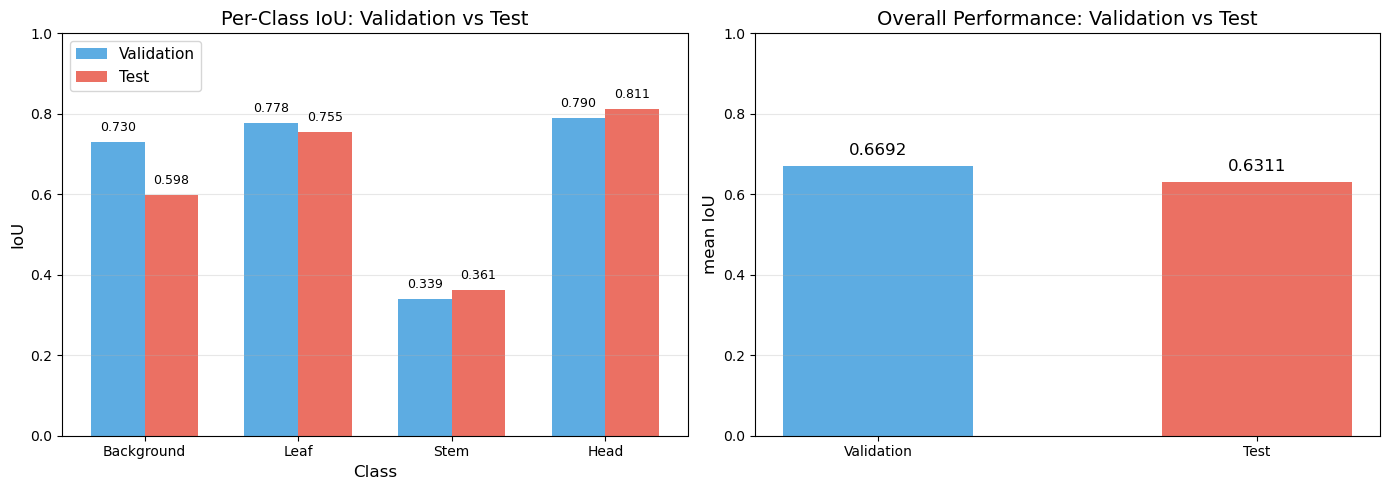

In [15]:
# Create comparison bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Per-class IoU comparison
x = np.arange(len(class_names))
width = 0.35

val_values = [val_class_ious[name.lower()] for name in class_names]
test_values = test_class_ious

ax1.bar(x - width/2, val_values, width, label='Validation', alpha=0.8, color='#3498db')
ax1.bar(x + width/2, test_values, width, label='Test', alpha=0.8, color='#e74c3c')

ax1.set_xlabel('Class', fontsize=12)
ax1.set_ylabel('IoU', fontsize=12)
ax1.set_title('Per-Class IoU: Validation vs Test', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(class_names)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0, 1])

# Add value labels on bars
for i, (val, test) in enumerate(zip(val_values, test_values)):
    ax1.text(i - width/2, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=9)
    ax1.text(i + width/2, test + 0.02, f'{test:.3f}', ha='center', va='bottom', fontsize=9)

# Mean IoU comparison
datasets = ['Validation', 'Test']
mious = [val_miou, test_miou]
colors = ['#3498db', '#e74c3c']

bars = ax2.bar(datasets, mious, color=colors, alpha=0.8, width=0.5)
ax2.set_ylabel('mean IoU', fontsize=12)
ax2.set_title('Overall Performance: Validation vs Test', fontsize=14)
ax2.set_ylim([0, 1])
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, miou in zip(bars, mious):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{miou:.4f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

### Check Example Predictions

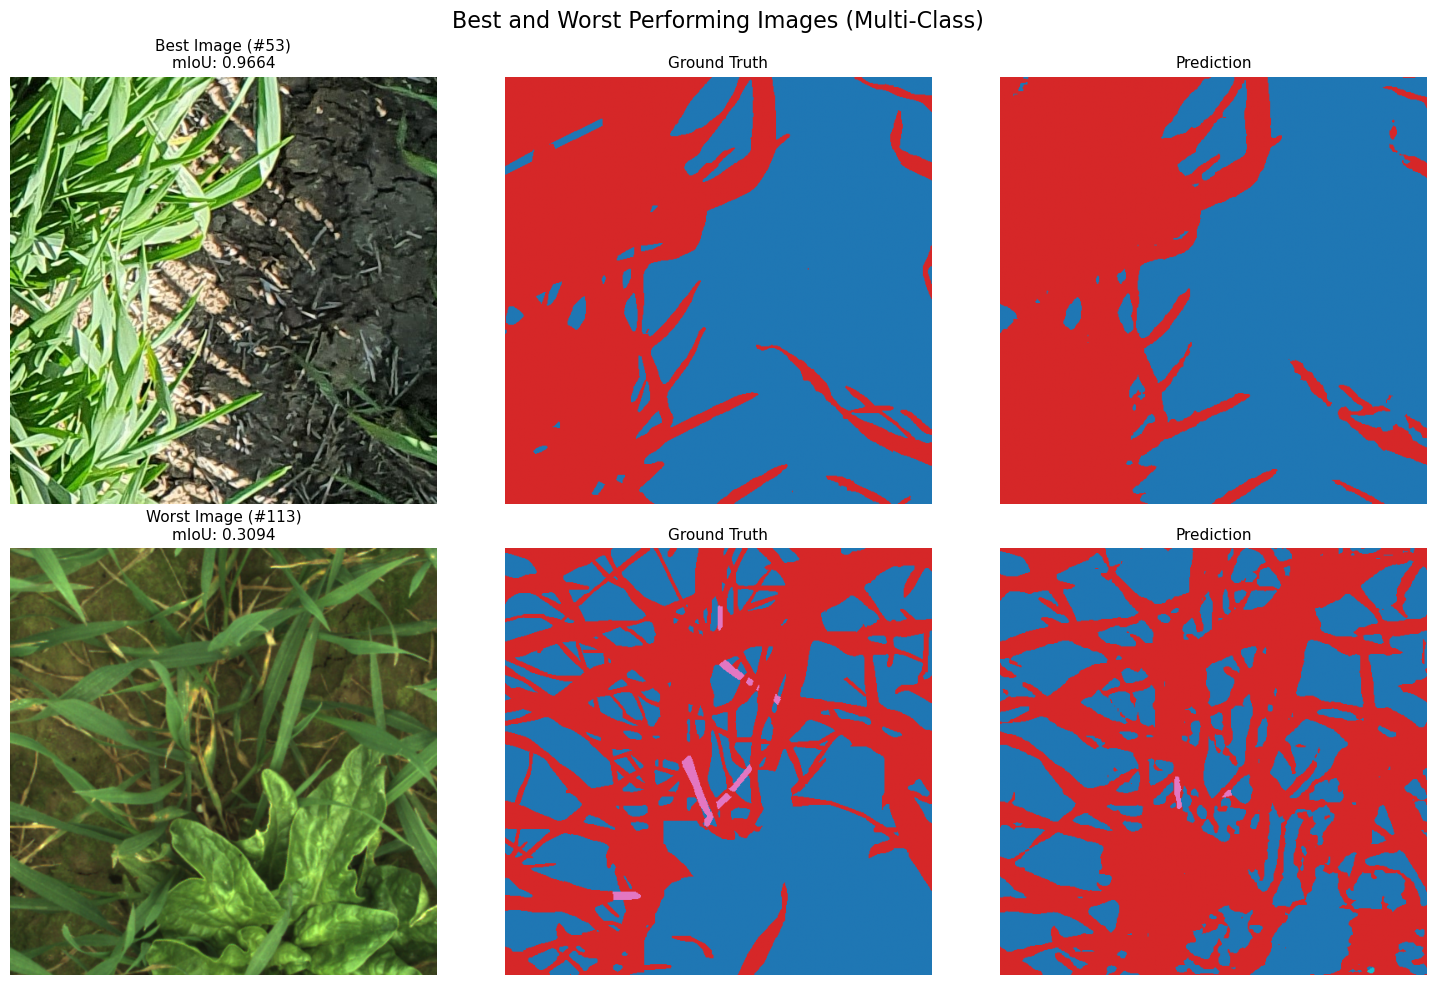

In [19]:
# Find best and worst performing images (excluding images with only one class)
image_mious = test_ious.mean(axis=1)

# Filter out images that have only background or lack variety
valid_indices = []
for idx in range(len(test_dataset)):
    _, mask = test_dataset[idx]
    unique_classes = torch.unique(mask).cpu().numpy()
    # Only consider images with at least 2 classes
    if len(unique_classes) >= 2:
        valid_indices.append(idx)

# Get mIoU values for valid images
valid_mious = [(idx, image_mious[idx]) for idx in valid_indices]
valid_mious.sort(key=lambda x: x[1])  # Sort by mIoU

# Best and worst from valid images
worst_idx, worst_miou = valid_mious[0]
best_idx, best_miou = valid_mious[-1]

# Visualise best and worst performing images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Best and Worst Performing Images (Multi-Class)', fontsize=16, y=0.98)

# Get best and worst images
best_image, best_mask = test_dataset[best_idx]
worst_image, worst_mask = test_dataset[worst_idx]

# Denormalise images for display
def denormalize(img):
    img = img.clone()
    for t, m, s in zip(img, IMAGENET_MEAN, IMAGENET_STD):
        t.mul_(s).add_(m)
    return torch.clamp(img, 0, 1).permute(1, 2, 0).numpy()

# Get predictions
model.eval()
with torch.no_grad():
    best_pred = model(best_image.unsqueeze(0).to(device))
    best_pred = torch.argmax(best_pred, dim=1).squeeze().cpu().numpy()
    
    worst_pred = model(worst_image.unsqueeze(0).to(device))
    worst_pred = torch.argmax(worst_pred, dim=1).squeeze().cpu().numpy()

# Best image row
axes[0, 0].imshow(denormalize(best_image))
axes[0, 0].set_title(f"Best Image (#{best_idx})\nmIoU: {best_miou:.4f}", fontsize=11)
axes[0, 0].axis("off")

axes[0, 1].imshow(best_mask.cpu().numpy(), cmap="tab10", vmin=0, vmax=3)
axes[0, 1].set_title("Ground Truth", fontsize=11)
axes[0, 1].axis("off")

axes[0, 2].imshow(best_pred, cmap="tab10", vmin=0, vmax=3)
axes[0, 2].set_title("Prediction", fontsize=11)
axes[0, 2].axis("off")

# Worst image row
axes[1, 0].imshow(denormalize(worst_image))
axes[1, 0].set_title(f"Worst Image (#{worst_idx})\nmIoU: {worst_miou:.4f}", fontsize=11)
axes[1, 0].axis("off")

axes[1, 1].imshow(worst_mask.cpu().numpy(), cmap="tab10", vmin=0, vmax=3)
axes[1, 1].set_title("Ground Truth", fontsize=11)
axes[1, 1].axis("off")

axes[1, 2].imshow(worst_pred, cmap="tab10", vmin=0, vmax=3)
axes[1, 2].set_title("Prediction", fontsize=11)
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()